In [4]:
from duckduckgo_search import ddg_images
from typing import List, Dict, Any
from fastcore.all import *
from fastai.vision.widgets import *


In [5]:
imgs = ddg_images("shar pei", max_results=1)

In [6]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return ddg_images(term, max_results=max_images)

In [7]:
bear_types = ['grizzly','black','teddy']
path = Path('bears')

In [8]:
from fastai.vision import utils as vutils
from fastai.data.transforms import get_image_files



IMG_LIMIT = 100

path.mkdir(exist_ok=True)
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    fns = get_image_files(dest)
    if len(fns) >= IMG_LIMIT:
        continue
    search_results = search_images(f'{o} bear', max_images=IMG_LIMIT)
    urls = [res["image"] for res in search_results]
    imgs = vutils.download_images(dest, urls=urls)

Searching for 'grizzly bear'
Searching for 'teddy bear'


In [9]:
fns = get_image_files(path)

In [10]:
failed = vutils.verify_images(fns)
failed

(#2) [Path('bears/grizzly/e68d805e-73d0-4e45-a587-213060980119.jpg'),Path('bears/grizzly/3a682087-eaa8-43d0-ba52-1093d91b1909.jpg')]

In [11]:
failed.map(Path.unlink);

In [12]:
from fastai.data import block, transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import RandomSplitter, Resize


bears = block.DataBlock(
    blocks=(ImageBlock, block.CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=transforms.parent_label,
    item_tfms=Resize(128))

In [13]:
dls = bears.dataloaders(path)

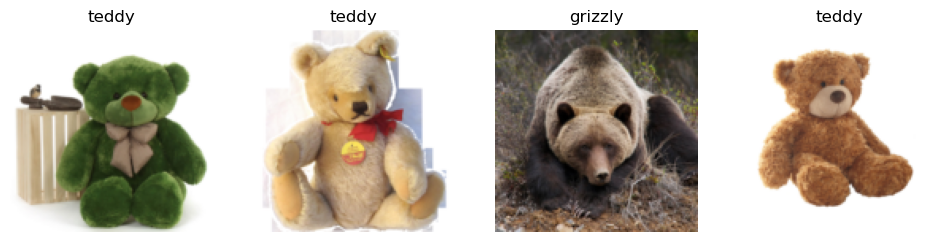

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

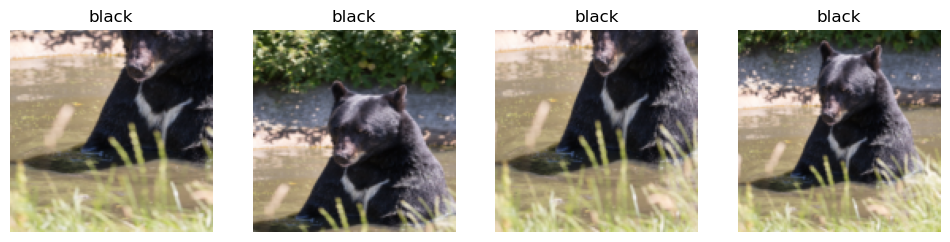

In [15]:
from fastai.vision.learner import Resize, RandomResizedCrop

bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

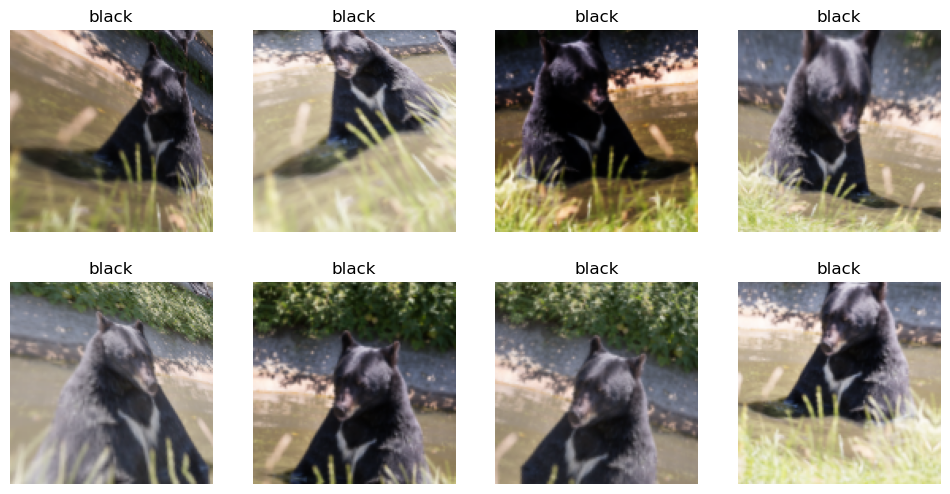

In [16]:
from fastai.vision.augment import aug_transforms

# Data Augmentation
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [18]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [21]:
from fastai.vision.learner import vision_learner
from fastai.vision.all import resnet18, error_rate

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/home/matt/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.139044,0.158420,0.051546,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.125838,0.021767,0.010309,00:07
1,0.075250,0.004783,0.000000,00:08
2,0.054130,0.000779,0.000000,00:07
3,0.042706,0.001251,0.000000,00:07


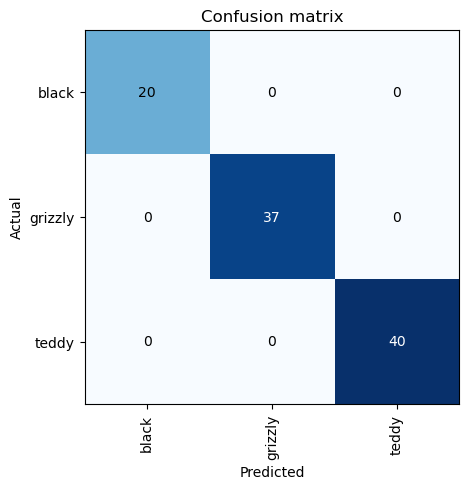

In [23]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

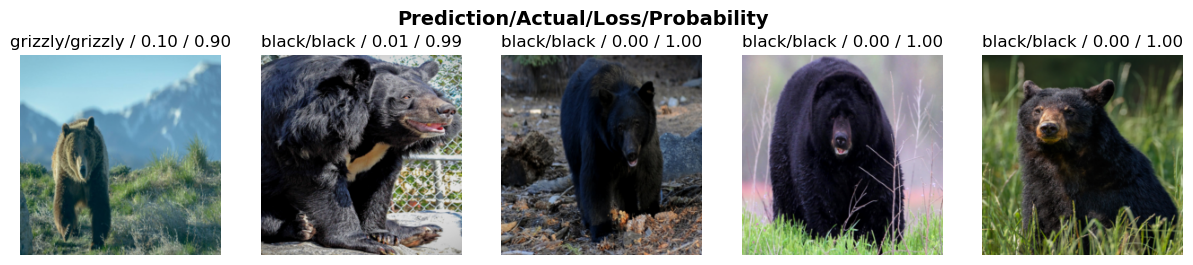

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
# Clearing out invalid data.
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

# For moving data from one folder to another
# This assumes you're using the folder names as categories
for idx, category in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path / category)


In [28]:
learn.export()

epoch,train_loss,valid_loss,error_rate,time
0,1.054303,0.109499,0.051546,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.113899,0.007908,0.000000,00:08
1,0.084931,0.002921,0.000000,00:07
2,0.059730,0.006190,0.000000,00:08
3,0.047101,0.003648,0.000000,00:08


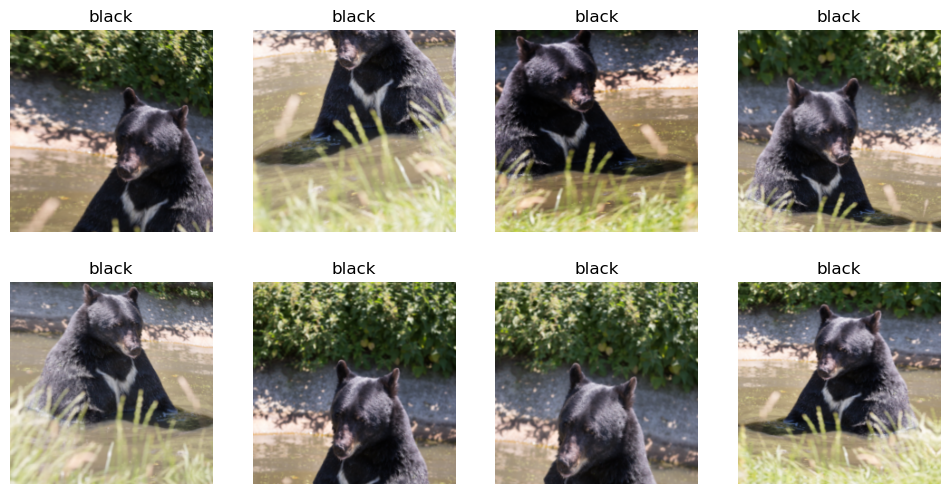

In [27]:
# retrain
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

# Actually using the model

In [34]:
learn.export()

In [35]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [37]:
from fastai.learner import load_learner
learn_inf = load_learner(path/'export.pkl')

In [38]:
learn_inf.predict('bears/black/feb76760-e1aa-4f53-aa74-ab72354023ff.jpg')

('black', TensorBase(0), TensorBase([9.9999e-01, 2.0187e-06, 5.3320e-06]))

In [39]:
learn_inf.predict('bears/grizzly/79b20ad1-2f7e-4c00-baa0-c34c70365e46.jpg')

('grizzly', TensorBase(1), TensorBase([9.5000e-08, 1.0000e+00, 4.5343e-09]))

In [40]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']